### Packages

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import importlib, import_ipynb
import data_clean_order as data
import tensorflow as tf
from tensorflow.data import experimental
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')

### Loading ordered data from data_clean_order_text.ipynb

In [3]:
%store -r ordered_super_alpha_text
%store -r ordered_class_alpha_text
%store -r ordered_sem_clusters_desc_text
%store -r ordered_sem_clusters_asc_text
%store -r ordered_sem_clusters_shuffled_per_superclass_text
%store -r test_df

In [4]:
# Experimental data orderings on headlines TRAIN EXAMPLES
X1_train = ordered_super_alpha_text['cleaned_headline']
X2_train = ordered_class_alpha_text['cleaned_headline']
X3_train = ordered_sem_clusters_desc_text['cleaned_headline']
X4_train = ordered_sem_clusters_asc_text['cleaned_headline']
X5_train = ordered_sem_clusters_shuffled_per_superclass_text['cleaned_headline']

# Experimental data orderings on short_description #TODO

# TRAIN LABELS
Y1_train = ordered_super_alpha_text['superclass']
Y2_train = ordered_class_alpha_text['superclass']
Y3_train = ordered_sem_clusters_desc_text['superclass']
Y4_train = ordered_sem_clusters_asc_text['superclass']
Y5_train = ordered_sem_clusters_shuffled_per_superclass_text['superclass']

# TEST EXAMPLES
X_test = test_df['cleaned_headline']
Y_test = test_df['superclass']



In [5]:
Y1_train[:100]

0     COMMUNITIES
1     COMMUNITIES
2     COMMUNITIES
3     COMMUNITIES
4     COMMUNITIES
         ...     
95    COMMUNITIES
96    COMMUNITIES
97    COMMUNITIES
98    COMMUNITIES
99    COMMUNITIES
Name: superclass, Length: 100, dtype: object

In [6]:
Y2_train[:100]

0     CULTURE
1     CULTURE
2     CULTURE
3     CULTURE
4     CULTURE
       ...   
95    CULTURE
96    CULTURE
97    CULTURE
98    CULTURE
99    CULTURE
Name: superclass, Length: 100, dtype: object

In [7]:
Y3_train[:100]

68504    POLITICS
69260    POLITICS
99276    POLITICS
68220    POLITICS
56955    POLITICS
           ...   
86926    POLITICS
51250    POLITICS
35939    POLITICS
18413    POLITICS
27379    POLITICS
Name: superclass, Length: 100, dtype: object

In [8]:
Y4_train[:100]

207438    CULTURE
193271    CULTURE
201761    CULTURE
146673    CULTURE
190637    CULTURE
           ...   
153890    CULTURE
171095    CULTURE
143223    CULTURE
169032    CULTURE
195877    CULTURE
Name: superclass, Length: 100, dtype: object

In [9]:
Y5_train[:100]

72180     POLITICS
112162    POLITICS
74004     POLITICS
97834     POLITICS
96919     POLITICS
            ...   
57938     POLITICS
96668     POLITICS
70744     POLITICS
62196     POLITICS
69314     POLITICS
Name: superclass, Length: 100, dtype: object

In [10]:
Y_test[:100]

166912           FAMILY
137790    ENTERTAINMENT
153816          CULTURE
23683          POLITICS
173834           HEALTH
              ...      
187842        LIFESTYLE
115679          CULTURE
7876           POLITICS
31449         LIFESTYLE
45309         LIFESTYLE
Name: superclass, Length: 100, dtype: object

## Tokenization and Vectorization


### One-hot encoding and indexing of train and test data

In [11]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 27262


# EXPERIMENT ORDER 1

In [12]:
# ORDER 1 TRAIN DATA
X_train = X1_train
Y_train = Y1_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 53645


### Model training using embedding layer and RNN (Baseline)

In [13]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 70)            3755150   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          17280     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 9)                 2

In [14]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

Epoch 1/15
1310/1310 [==============================] - 103s 73ms/step - loss: 1.5200 - accuracy: 0.4919
Epoch 2/15
1310/1310 [==============================] - 94s 72ms/step - loss: 1.1119 - accuracy: 0.6503
Epoch 3/15
1310/1310 [==============================] - 95s 73ms/step - loss: 1.0056 - accuracy: 0.6860
Epoch 4/15
1310/1310 [==============================] - 97s 74ms/step - loss: 0.9391 - accuracy: 0.7085
Epoch 5/15
1310/1310 [==============================] - 94s 72ms/step - loss: 0.8885 - accuracy: 0.7251
Epoch 6/15
1310/1310 [==============================] - 96s 73ms/step - loss: 0.8503 - accuracy: 0.7377
Epoch 7/15
1310/1310 [==============================] - 96s 74ms/step - loss: 0.8130 - accuracy: 0.7507
Epoch 8/15
1310/1310 [==============================] - 95s 73ms/step - loss: 0.7792 - accuracy: 0.7616
Epoch 9/15
1310/1310 [==============================] - 95s 73ms/step - loss: 0.7512 - accuracy: 0.7713
Epoch 10/15
1310/1310 [==============================] - 96s 73

In [15]:
# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

test loss and accuracy: 3.1377480030059814 0.20288749039173126


In [16]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    #plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

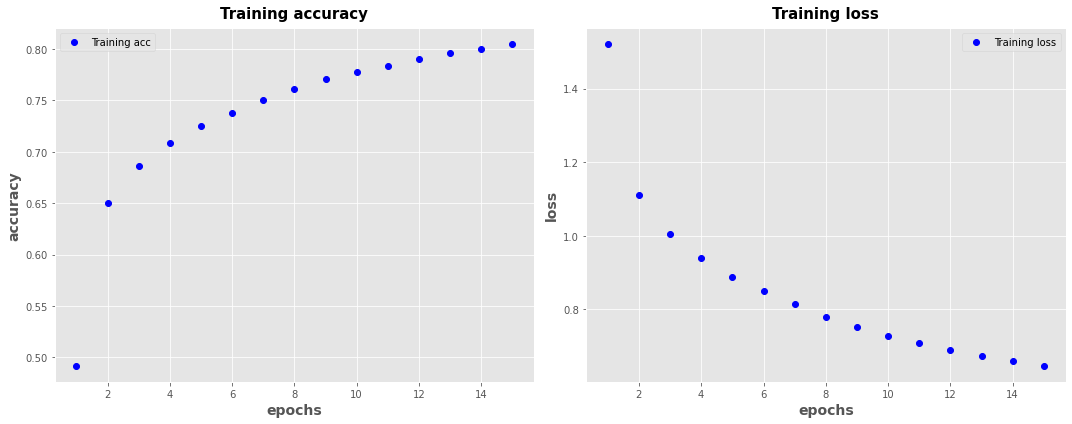

In [17]:
plot_loss_accuracy(history)

# EXPERIMENT ORDER 2

In [18]:
# ORDER 2 TRAIN DATA
X_train = X2_train
Y_train = Y2_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 57645


### Model training using embedding layer and RNN (Baseline)

In [19]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 70)            4035150   
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                

In [20]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1310/1310 [==============================] - 106s 75ms/step - loss: 1.5369 - accuracy: 0.4863
Epoch 2/15
1310/1310 [==============================] - 98s 75ms/step - loss: 1.1122 - accuracy: 0.6493
Epoch 3/15
1310/1310 [==============================] - 98s 75ms/step - loss: 1.0063 - accuracy: 0.6858
Epoch 4/15
1310/1310 [==============================] - 100s 76ms/step - loss: 0.9435 - accuracy: 0.7067
Epoch 5/15
1310/1310 [==============================] - 99s 76ms/step - loss: 0.8956 - accuracy: 0.7228
Epoch 6/15
1310/1310 [==============================] - 98s 75ms/step - loss: 0.8526 - accuracy: 0.7372
Epoch 7/15
1310/1310 [==============================] - 98s 75ms/step - loss: 0.8148 - accuracy: 0.7496
Epoch 8/15
1310/1310 [==============================] - 99s 75ms/step - loss: 0.7826 - accuracy: 0.7605
Epoch 9/15
1310/1310 [==============================] - 98s 74ms/step - loss: 0.7549 - accuracy: 0.7699
Epoch 10/15
1310/1310 [==============================] - 99s 7

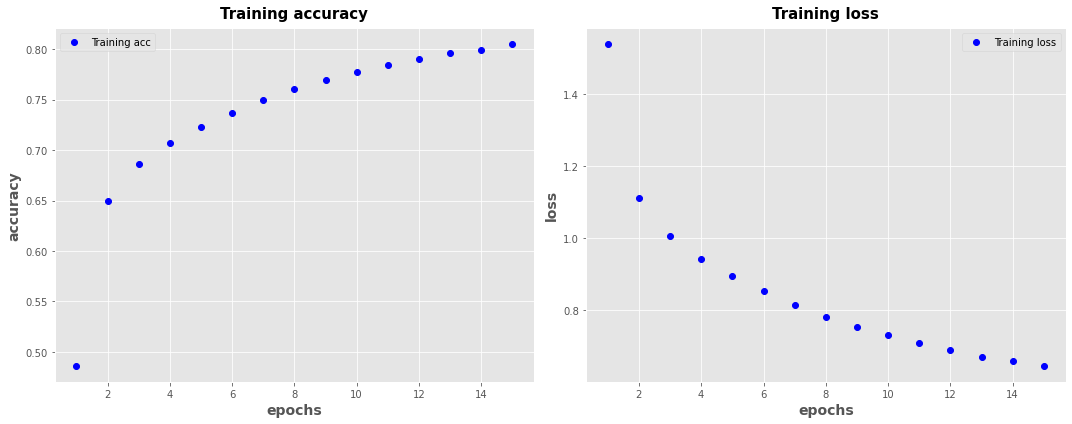

In [21]:
plot_loss_accuracy(history)

# EXPERIMENT ORDER 3

In [22]:
# ORDER 3 TRAIN DATA
X_train = X3_train
Y_train = Y3_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 57645


### Model training using embedding layer and RNN (Baseline)

In [23]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 70)            4035150   
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                

In [24]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1310/1310 [==============================] - 108s 77ms/step - loss: 1.5404 - accuracy: 0.4856
Epoch 2/15
1310/1310 [==============================] - 100s 77ms/step - loss: 1.1138 - accuracy: 0.6492
Epoch 3/15
1310/1310 [==============================] - 100s 76ms/step - loss: 1.0006 - accuracy: 0.6871
Epoch 4/15
1310/1310 [==============================] - 99s 76ms/step - loss: 0.9351 - accuracy: 0.7091
Epoch 5/15
1310/1310 [==============================] - 102s 78ms/step - loss: 0.8862 - accuracy: 0.7251
Epoch 6/15
1310/1310 [==============================] - 100s 76ms/step - loss: 0.8449 - accuracy: 0.7388
Epoch 7/15
1310/1310 [==============================] - 100s 77ms/step - loss: 0.8098 - accuracy: 0.7513
Epoch 8/15
1310/1310 [==============================] - 101s 77ms/step - loss: 0.7781 - accuracy: 0.7617
Epoch 9/15
1310/1310 [==============================] - 99s 76ms/step - loss: 0.7515 - accuracy: 0.7706
Epoch 10/15
1310/1310 [==============================] - 

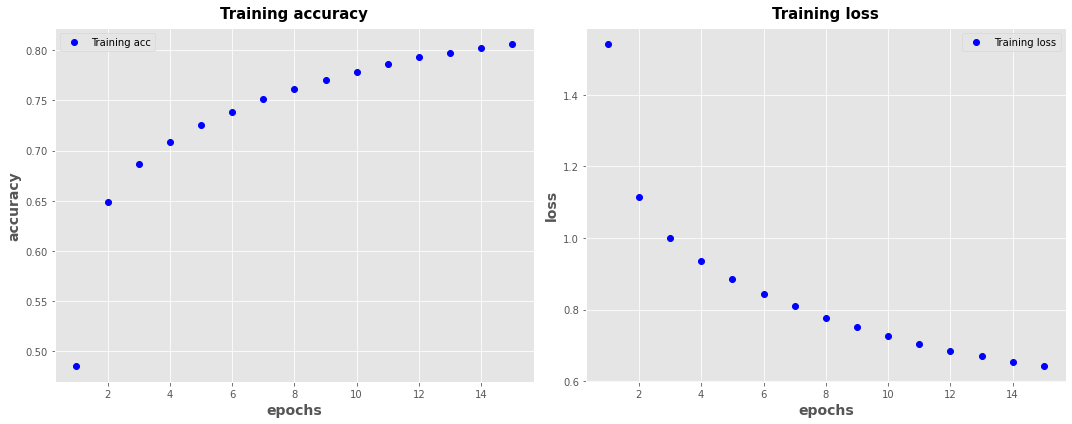

In [25]:
plot_loss_accuracy(history)

# EXPERIMENT ORDER 4

In [26]:
# ORDER 4 TRAIN DATA
X_train = X4_train
Y_train = Y4_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 57645


### Model training using embedding layer and RNN (Baseline)

In [27]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 70)            4035150   
                                                                 
 bidirectional_6 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 32)                5152      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 9)                

In [28]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1310/1310 [==============================] - 112s 79ms/step - loss: 1.5212 - accuracy: 0.4879
Epoch 2/15
1310/1310 [==============================] - 145s 111ms/step - loss: 1.1056 - accuracy: 0.6506
Epoch 3/15
1310/1310 [==============================] - 122s 93ms/step - loss: 1.0012 - accuracy: 0.6866
Epoch 4/15
1310/1310 [==============================] - 110s 84ms/step - loss: 0.9358 - accuracy: 0.7091
Epoch 5/15
1310/1310 [==============================] - 120s 92ms/step - loss: 0.8868 - accuracy: 0.7264
Epoch 6/15
1310/1310 [==============================] - 115s 88ms/step - loss: 0.8420 - accuracy: 0.7415
Epoch 7/15
1310/1310 [==============================] - 115s 88ms/step - loss: 0.8081 - accuracy: 0.7525
Epoch 8/15
1310/1310 [==============================] - 117s 90ms/step - loss: 0.7728 - accuracy: 0.7643
Epoch 9/15
1310/1310 [==============================] - 124s 94ms/step - loss: 0.7471 - accuracy: 0.7731
Epoch 10/15
1310/1310 [==============================]

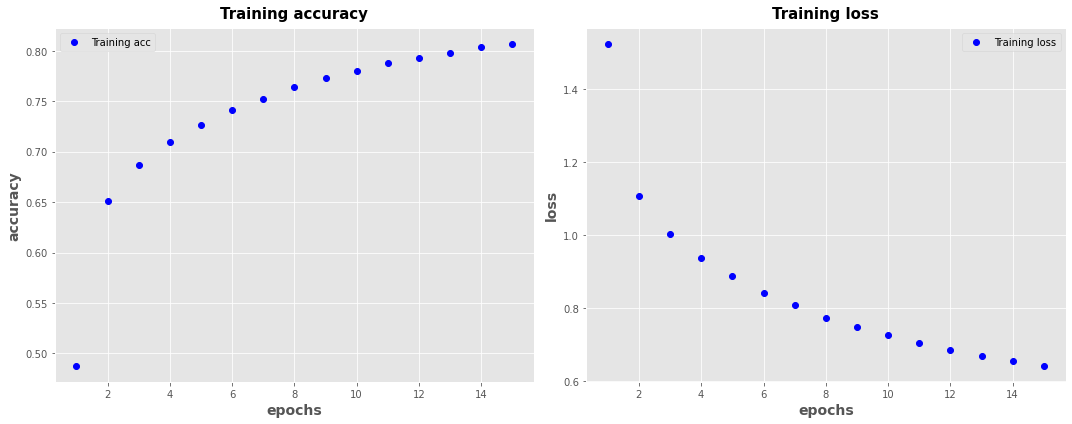

In [29]:
plot_loss_accuracy(history)

# EXPERIMENT ORDER 5

In [30]:
# ORDER 5 TRAIN DATA
X_train = X5_train
Y_train = Y5_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 57645


### Model training using embedding layer and RNN (Baseline)

In [31]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 70)            4035150   
                                                                 
 bidirectional_8 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 32)                5152      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 9)                

In [32]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1310/1310 [==============================] - 145s 99ms/step - loss: 1.5201 - accuracy: 0.4953
Epoch 2/15
1310/1310 [==============================] - 143s 109ms/step - loss: 1.1082 - accuracy: 0.6512
Epoch 3/15
1310/1310 [==============================] - 132s 101ms/step - loss: 0.9969 - accuracy: 0.6888
Epoch 4/15
1310/1310 [==============================] - 138s 106ms/step - loss: 0.9314 - accuracy: 0.7104
Epoch 5/15
1310/1310 [==============================] - 131s 100ms/step - loss: 0.8797 - accuracy: 0.7270
Epoch 6/15
1310/1310 [==============================] - 134s 102ms/step - loss: 0.8406 - accuracy: 0.7410
Epoch 7/15
1310/1310 [==============================] - 144s 110ms/step - loss: 0.8028 - accuracy: 0.7539
Epoch 8/15
1310/1310 [==============================] - 135s 103ms/step - loss: 0.7751 - accuracy: 0.7627
Epoch 9/15
1310/1310 [==============================] - 134s 102ms/step - loss: 0.7463 - accuracy: 0.7720
Epoch 10/15
1310/1310 [========================

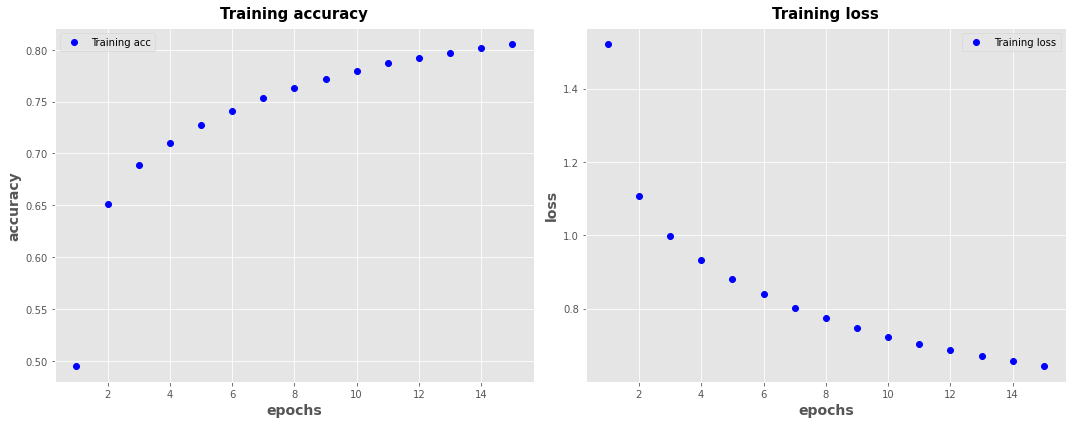

In [33]:
plot_loss_accuracy(history)